# Analysis of Alta Bates Closure

This notebook will perform some of the analysis used in the case study subsection on Alta Bates closure. 

## Imports and Setup

### Import Packages

In [1]:
import sys
import os
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
from matplotlib import colorbar
from matplotlib.colors import Normalize

In [3]:
plt.rcParams['figure.figsize'] = [20, 12]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 36
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36

### Import Data

In [4]:
DATA_PATH = 'all-data/'

race_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/ethnicity_split_all.csv')
health_ins_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/health_ins_split_all.csv')
income_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/income_split_all.csv')

In [5]:
total_population_by_tract =\
        np.copy(health_ins_split_df_all[health_ins_split_df_all['Variable'] == 'No_Health_Ins_ACS_10_14']['Value']) +\
        np.copy(health_ins_split_df_all[health_ins_split_df_all['Variable'] == 'One_Plus_Health_Ins']['Value'])

In [6]:
# Load Facilities data.
al_fac_df = pd.read_csv(DATA_PATH + 'hospital-data/alameda-emergency-facilites.csv').iloc[:18, :].copy()
cc_fac_df = pd.read_csv(DATA_PATH + 'hospital-data/cc-healthcare-dataset.csv')
al_facilites_long_lats = np.array(al_fac_df[['LONGITUDE', 'LATITUDE']])
cc_facilites_long_lats = np.array(cc_fac_df[['LONGITUDE', 'LATITUDE']])
facilites_long_lats = np.vstack((al_facilites_long_lats, cc_facilites_long_lats))

In [7]:
# Load tract-facility distance matrix, computed via the Google Maps API. 
# Distances refer to the driving distance between pairs of locations. 
gmaps_distance_matrix = pd.read_csv(DATA_PATH + 'all_travel_distance_matrix.csv')

# Remove unnecessary first column.
gmaps_distance_matrix = gmaps_distance_matrix.iloc[:, 1:].copy()

# Convert to numpy array, and divide by 1000 to convert meters to kilometers. 
tract_facility_distance_matrix = np.array(gmaps_distance_matrix)[:, :] / 1000.0

In [8]:
num_beds_arr = list(al_fac_df['TOTAL_NUMBER_BEDS']) + list(cc_fac_df['TOTAL_NUMBER_BEDS'])

# Load Increase for Nearby Facilities

We assume that every customer travels to the nearest open facility. Where do current Alta Bates customers go when it is closed? 

## Setup Functions

In [9]:
def get_allocs(distances_matrix, facs_to_open_list):
    '''
    Returns the distances to the assigned facilities,
    and a list of the facilities each tract is assigned to.
    
    distances_matrix: 2D array. Each entry is the pairwise distance between a census tract
    and facility. 
    facs_to_open_list: List of integers. The facilities which will be open. 
    '''
    distances = np.min(distances_matrix[:, facs_to_open_list], axis=1)
    fac_assignments_relative_indices = np.argmin(distances_matrix[:, facs_to_open_list], axis=1)
    fac_assignments_absolute_indices = [facs_to_open_list[i] for i in fac_assignments_relative_indices]
    return distances, fac_assignments_absolute_indices

In [10]:
def displacement(old_facs_to_open, new_facs_to_open): 
    '''
    old_facs_to_open: List of integers. The old facilities which were open. 
    old_facs_to_open: List of integers. The new facilities to open.
    '''
    old_dist, old_fac_assignments = get_allocs(tract_facility_distance_matrix, 
                                     old_facs_to_open)
    new_dist, new_fac_assignments = get_allocs(tract_facility_distance_matrix, 
                                     new_facs_to_open)
    new_assignments_dict = {k: [] for k in old_fac_assignments}
    tract_indices_dict = {k: [] for k in old_fac_assignments}
    counter = 0
    for old_fac, new_fac in zip(old_fac_assignments, new_fac_assignments): 
        new_assignments_dict[old_fac].append(new_fac)
        tract_indices_dict[old_fac].append(counter)
        counter += 1
    return new_assignments_dict, tract_indices_dict

In [11]:
def load_increase(new_assignment_list, displaced_tract_indices_list, 
                  num_facs, population_arr):
    '''
    Returns a dictionary of the load increase at each facility. 
    
    new_assignment_list: List of integers. Facility ID that each displaced census tract is assigned to. 
    displaced_tract_indices_list: The indices of the census tracts which are displaced. These
    are exactly the tracts which previous traveled to facility 16. 
    num_facs: Total number of facilities, including closed and open. Should be 26.
    population_arr: 1D array or list of floats. The population at each census tract.
    '''
    fac_load_increase = {i: 0.0 for i in range(num_facs)}
    for fac_num, tract_num in zip(new_assignment_list, displaced_tract_indices_list):
        population = population_arr[int(tract_num)]
        fac_load_increase[int(fac_num)] += population
    return fac_load_increase

In [12]:
def get_original_load_dict(new_assignment_dict, tract_indices_dict, 
                  num_facs, population_arr): 
    fac_load_original = {i: 0.0 for i in range(num_facs)}
    for fac_source in new_assignment_dict.keys(): 
        if fac_source != 1: 
            new_assignment_list = new_assignment_dict[fac_source]
            tract_indices_list = tract_indices_dict[fac_source]            
            for fac_num, tract_num in zip(new_assignment_list, tract_indices_list):
                population = population_arr[int(tract_num)]
                fac_load_original[int(fac_num)] += population
    return fac_load_original

## Analysis

### Number of Customers per Facility, Before/After

In [13]:
cur_facs = [x for x in range(26) if x < 13 or x > 17]
cur_facs_no_ab = [x for x in cur_facs if x != 1]

In [50]:
distances, assignments = get_allocs(tract_facility_distance_matrix, cur_facs)

In [16]:
cur_ab_customer_indices = [i for i in range(tract_facility_distance_matrix.shape[0]) if assignments[i] == 1]

In [17]:
sum(total_population_by_tract[cur_ab_customer_indices])

168853.0

In [23]:
alta_bates_new_assignments, tract_indices_dict = displacement(cur_facs, cur_facs_no_ab + [17])

In [28]:
alta_bates_new_assignments

{9: [9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9],
 6: [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6],
 5: [5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5],
 8: [8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8],
 10: [10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10],
 7: [7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  

In [29]:
alta_bates_new_assignments[1]

[4,
 4,
 11,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 21,
 21,
 2,
 2,
 2,
 21,
 2,
 2,
 20,
 2,
 2,
 2,
 2,
 21,
 2,
 2]

In [32]:
sorted(cur_facs_no_ab + [17])

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [35]:
fac_17_indices = np.where(np.argmin(tract_facility_distance_matrix[:, sorted(cur_facs_no_ab + [17])], axis=1) == 17)

In [36]:
list(fac_17_indices)

[array([470, 494, 497, 515, 526, 535, 541, 549, 551, 553, 555, 556, 563,
        566])]

In [46]:
cur_assignments_by_tract = np.argmin(tract_facility_distance_matrix[:, cur_facs], axis=1)

In [49]:
np.where(cur_assignments_by_tract == cur_facs.index(17))

ValueError: 17 is not in list

In [42]:
fac_17_indices[0]

array([470, 494, 497, 515, 526, 535, 541, 549, 551, 553, 555, 556, 563,
       566])

In [44]:
cur_facs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18, 19, 20, 21, 22, 23, 24, 25]

In [45]:
cur_assignments_by_tract

array([ 9,  9,  9,  9,  9,  9,  6,  9,  9,  9,  9,  6,  9,  9,  9,  9,  9,
        6,  9,  6,  9,  6,  9,  6,  9,  9,  6,  6,  9,  6,  9,  9,  6,  6,
        9,  6,  6,  9,  9,  6,  6,  6,  6,  6,  6,  5,  6,  6,  6,  5,  6,
        6,  6,  5,  6,  5,  6,  5,  6,  5,  6,  5,  5,  6,  5,  5,  5,  5,
        6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  8,  5,  5,  5,
        5,  5,  5,  8, 10,  5,  8,  5, 10,  5,  8,  5,  8,  5,  5,  8, 10,
       10,  8,  8,  8,  5,  7,  8,  8,  8, 10, 10,  8,  8,  7,  8,  8, 10,
       10, 10, 10,  8, 10, 10,  8, 10,  8, 12, 12,  8,  8, 12, 10, 10, 10,
        8, 10,  8,  8,  8, 10, 10,  8,  8,  8,  8, 10, 12,  7, 10, 10, 12,
        7, 10, 10,  8,  8, 10,  8, 12,  7,  8,  8,  8,  8,  7,  7,  8, 12,
       10,  8, 10,  7, 10, 19,  7, 12,  7, 19,  7, 12,  7, 12,  7,  0,  8,
        7,  7,  7,  8,  0,  7,  7,  7,  7,  7,  7,  7,  0, 12,  0,  7,  0,
        0,  0,  7,  7,  7,  0,  7,  0,  3,  0,  0, 10,  0,  3,  3,  0,  0,
        3,  0,  0,  3,  3

In [38]:
sorted(cur_ab_customer_indices)

[307,
 309,
 316,
 317,
 318,
 320,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 350,
 351,
 352,
 354,
 355,
 357,
 358,
 359,
 387,
 388,
 395,
 399,
 410,
 414,
 417,
 420]

In [ ]:
load_increase(alta_bates_new_assignments[1])

In [25]:
original_load_dict = get_original_load_dict(alta_bates_new_assignments, tract_indices_dict, len(num_beds_arr),
                                total_population_by_tract)

In [26]:
load_increase_dict = load_increase(alta_bates_new_assignments[1], 
                                   tract_indices_dict[1], len(num_beds_arr),
                                    total_population_by_tract)

In [27]:
load_increase_dict

{0: 0.0,
 1: 0.0,
 2: 140393.0,
 3: 0.0,
 4: 8363.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 5156.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 5798.000000000001,
 21: 9143.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0}

In [38]:
sum([load_increase_dict[i] for i in range(26)])

168853.0

In [27]:
num_alta_bates_customers = sum(load_increase_dict.values())

In [28]:
num_alta_bates_customers

168853.0

In [39]:
NUM_FACILITIES = 26

In [40]:
new_loads = [load_increase_dict[x] + original_load_dict[x] for x in range(NUM_FACILITIES)]
orig_loads = [original_load_dict[x] for x in range(NUM_FACILITIES)]

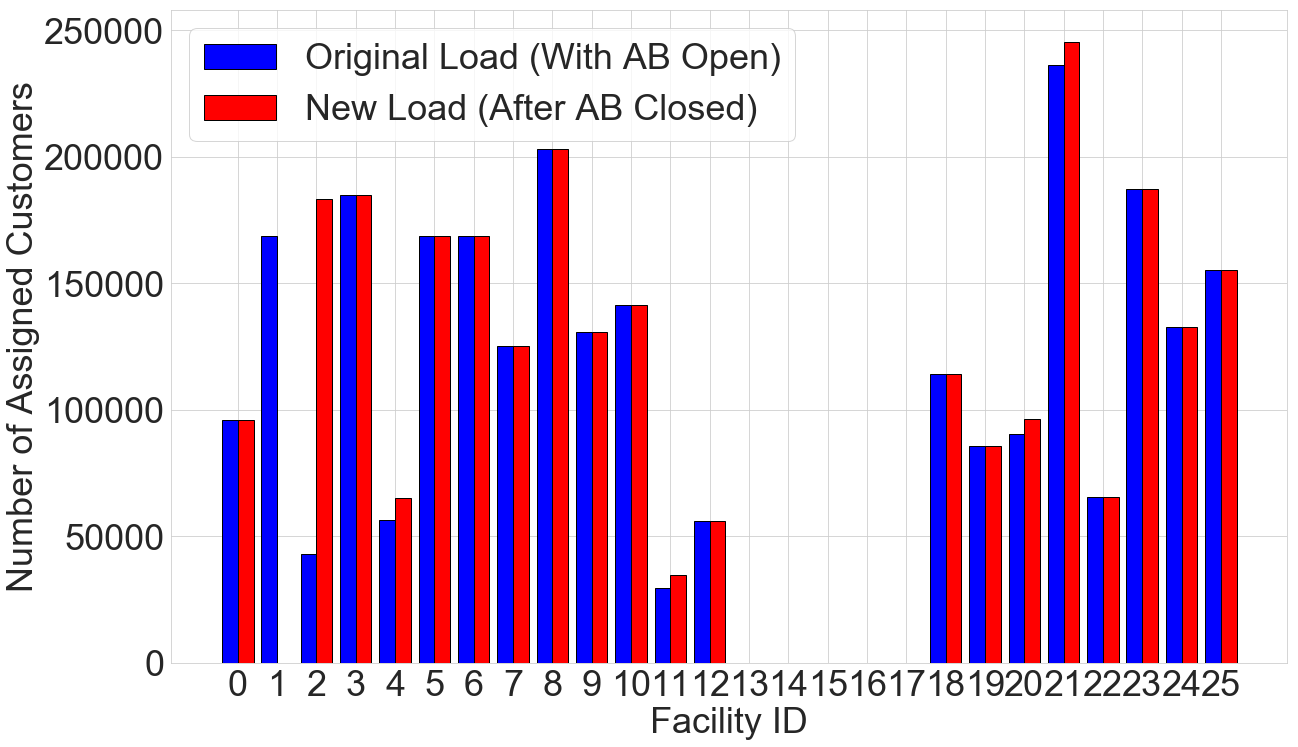

In [44]:
plt.bar(np.arange(NUM_FACILITIES), orig_loads,
        width=0.4, ec='k', label='Original Load (With AB Open)', color='b');
plt.bar([1], num_alta_bates_customers, width=0.4, ec='k', color='b');
plt.bar(np.arange(NUM_FACILITIES) + 0.4, new_loads, 
        width=0.4, ec='k', label='New Load (After AB Closed)', color='r');
plt.xticks(np.arange(NUM_FACILITIES) + 0.2, np.arange(NUM_FACILITIES))
plt.xlabel('Facility ID')
plt.ylabel('Number of Assigned Customers')
plt.legend()
plt.savefig('visualizations/alta-bates/load_increase_ab_closure_total_population.png');

In [43]:
sum(total_population_by_tract)

2640540.0

### Person-to-Bed Ratios, Before/After

In [48]:
global_num_beds_with_ab = sum([num_beds_arr[i] for i in cur_facs])
global_num_beds_no_ab = global_num_beds_with_ab - num_beds_arr[1]

In [49]:
global_num_beds_with_ab

4575.0

In [50]:
global_num_beds_no_ab

4228.0

In [51]:
global_person_bed_ratio_with_ab = sum(total_population_by_tract) / global_num_beds_with_ab
global_person_bed_ratio_no_ab = sum(total_population_by_tract) / global_num_beds_no_ab

In [52]:
global_person_bed_ratio_no_ab

624.5364238410596

In [53]:
global_person_bed_ratio_with_ab

577.1672131147541

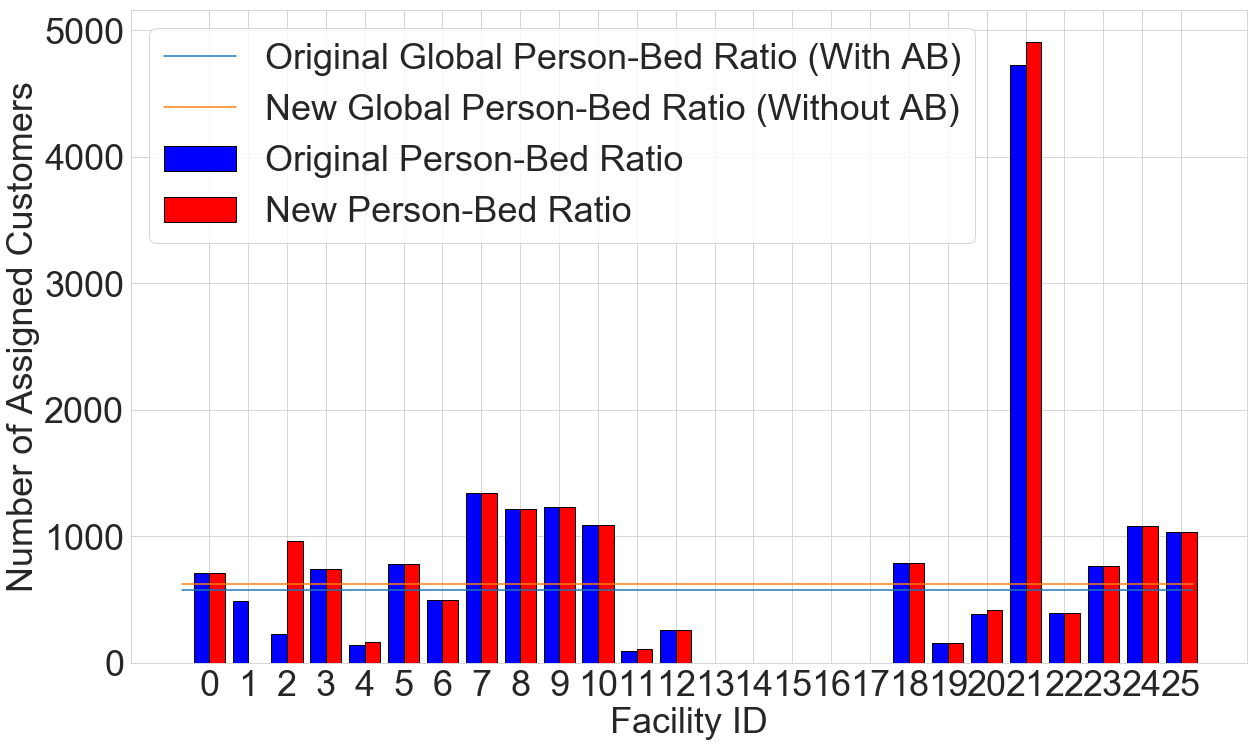

In [58]:
plt.bar(np.arange(NUM_FACILITIES), np.divide(np.array(orig_loads), num_beds_arr),
        width=0.4, ec='k', label='Original Person-Bed Ratio', color='b');
plt.bar([1], num_alta_bates_customers / num_beds_arr[1], width=0.4, ec='k', color='b');
plt.bar(np.arange(NUM_FACILITIES) + 0.4, np.divide(np.array(new_loads), num_beds_arr),
        width=0.4, ec='k', label='New Person-Bed Ratio', color='r');
plt.plot([-0.5, NUM_FACILITIES - 0.5], [global_person_bed_ratio_with_ab, global_person_bed_ratio_with_ab], 
         label='Original Global Person-Bed Ratio (With AB)')
plt.plot([-0.5, NUM_FACILITIES - 0.5], [global_person_bed_ratio_no_ab, global_person_bed_ratio_no_ab], 
         label='New Global Person-Bed Ratio (Without AB)')
plt.xlabel('Facility ID')
plt.ylabel('Number of Assigned Customers')
plt.xticks(np.arange(NUM_FACILITIES) + 0.2, np.arange(NUM_FACILITIES))
# plt.yscale('log')
plt.legend()
plt.savefig('visualizations/alta-bates/person_bed_ratios_alta_bates_closure.png');

### Distance Increases for AB Customers

In [61]:
old_dist_no_ab, old_fac_assignments_no_ab = get_allocs(tract_facility_distance_matrix, 
                                     cur_facs_no_ab)

In [62]:
old_dist, old_fac_assignments = get_allocs(tract_facility_distance_matrix, 
                                     cur_facs)

In [63]:
alta_bates_dist_increases_by_tract = (old_dist_no_ab - old_dist)[cur_ab_customer_indices]

In [68]:
alta_bates_pop_by_tract = total_population_by_tract[cur_ab_customer_indices]

In [69]:
pop_ints = [int(x) for x in alta_bates_pop_by_tract]

In [70]:
alta_bates_dist_increases_counts = np.repeat(alta_bates_dist_increases_by_tract, pop_ints)

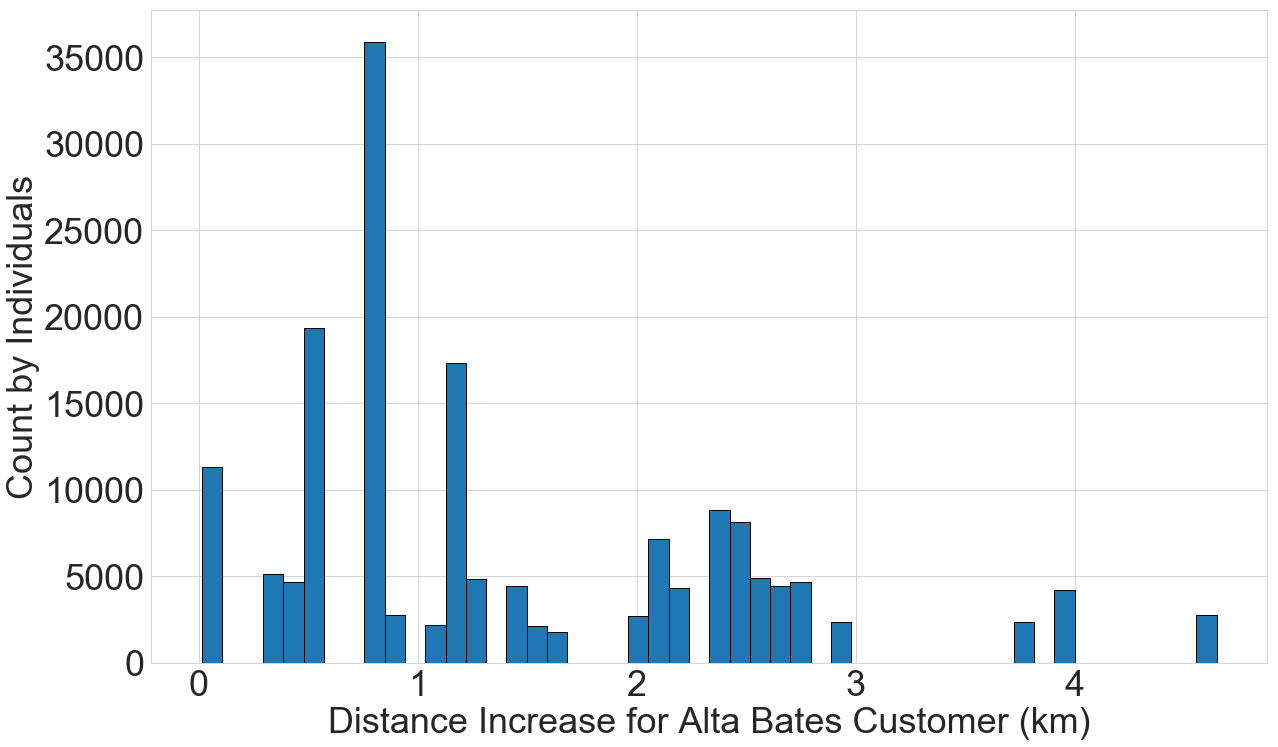

In [74]:
plt.hist(alta_bates_dist_increases_counts, bins=50, ec='k');
plt.xlabel('Distance Increase for Alta Bates Customer (km)')
plt.ylabel('Count by Individuals')
plt.savefig('visualizations/alta-bates/distance_increase_histogram_ab_customers.png');